In [1]:
import cv2

In [2]:
import time

In [3]:
import pyautogui

In [4]:
import numpy as np

In [5]:
import matplotlib.pyplot as plt

In [6]:
%matplotlib inline

In [7]:
import pytesseract

# Utility functions

In [8]:
def take_screen_shot(region=None):
    """
    region: four-integer tuple of the left, top,
    width, and height of the region to capture
    """
    
    print('Waiting 5 seconds before screen shot')
    print('Please change the browser window to semantris blocks mode')
    time.sleep(5)
    
    return pyautogui.screenshot(region=region)

In [9]:
FIGSIZE = (6,6)
def plot_img(arr, fs=FIGSIZE, cmap='gray', title=None):
    plt.figure(figsize=fs)
    plt.imshow(arr, cmap=cmap)
    plt.title(title)
    plt.show()

In [10]:
def bgr_to_hsv_value(color):
    """
    Convert a list of BGR color to HSV list
    """
    
    c = np.uint8([[color]])
    hsv = cv2.cvtColor(c, cv2.COLOR_BGR2HSV)
    
    return hsv[0][0]

In [11]:
"""
Improvised from the following stackoverflow answer
https://stackoverflow.com/a/48738145/2947248
"""

import cv2
import numpy as np
from IPython.display import clear_output, Image, display
from io import StringIO, BytesIO
import PIL.Image

def showarray(a, fmt='png'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

# Screen Processing

Waiting 5 seconds before screen shot
Please change the browser window to semantris blocks mode


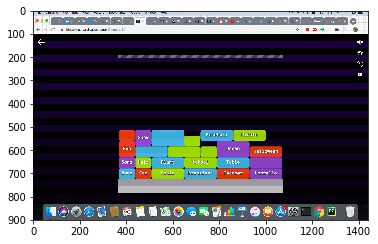

In [12]:
screen = take_screen_shot()
plot_img(screen)

### Crop screen shot

Waiting 5 seconds before screen shot
Please change the browser window to semantris blocks mode


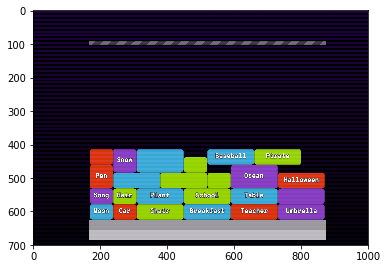

In [13]:
# region: four-integer tuple of the left, top
# width, and height of the region to capture
# for my system the screen is 1440 x 900
screen = take_screen_shot(region=(200, 100, 1000, 700))
plot_img(screen)

### Color tracking

In [14]:
frame = np.array(screen)

# Convert RGB to HSV
hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)

# define range of a color to track (blue) in HSV
# lower_color_range = np.array([90,50,50])
# upper_color_range = np.array([110,255,255])

# define range of a color to track (green) in HSV
lower_color_range = np.array([30,50,50])
upper_color_range = np.array([50,255,255])

# threshold the HSV image to get only blue colors
mask_color_range = cv2.inRange(hsv, lower_color_range, upper_color_range)

"""
To track multiple colors, you can bitwise-OR
two images with different colors

res = cv2.bitwise_or(res_blue, res_purple)
"""

# Bitwise-AND mask and original images
colored_res = cv2.bitwise_and(frame, frame, mask= mask_color_range)

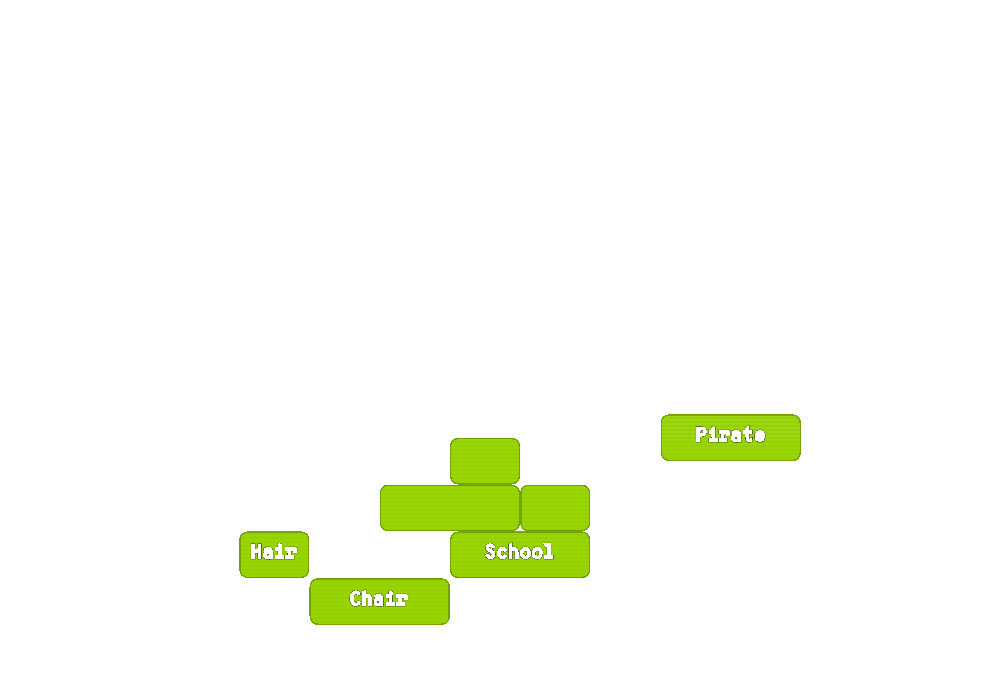

In [15]:
showarray(colored_res)

### Contour detection

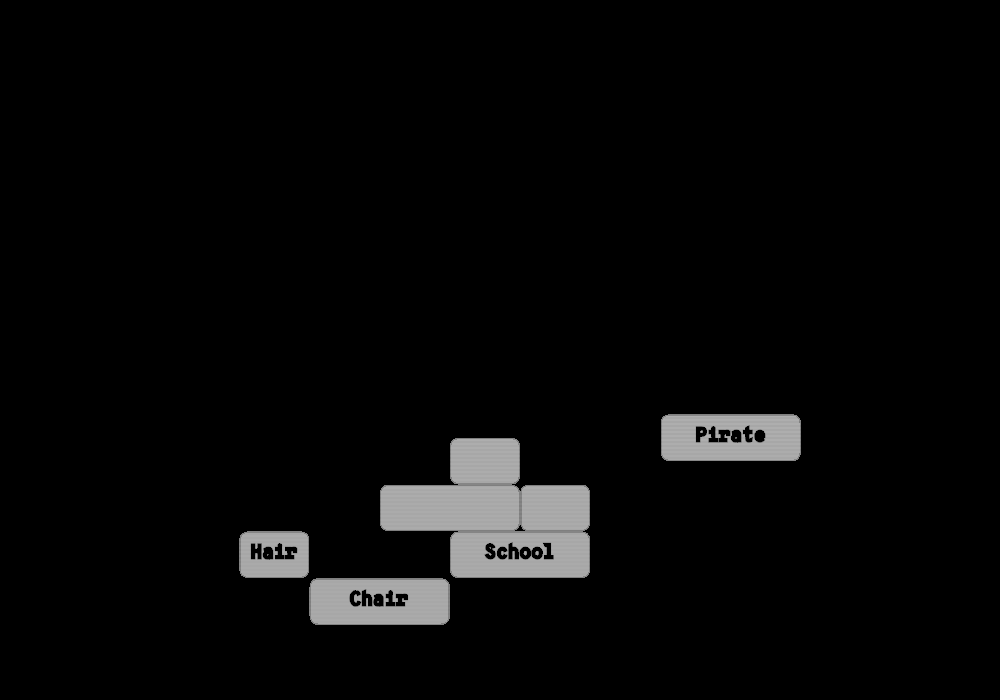

In [16]:
# grayscale conversion
imgray = cv2.cvtColor(colored_res, cv2.COLOR_RGB2GRAY)
showarray(imgray)

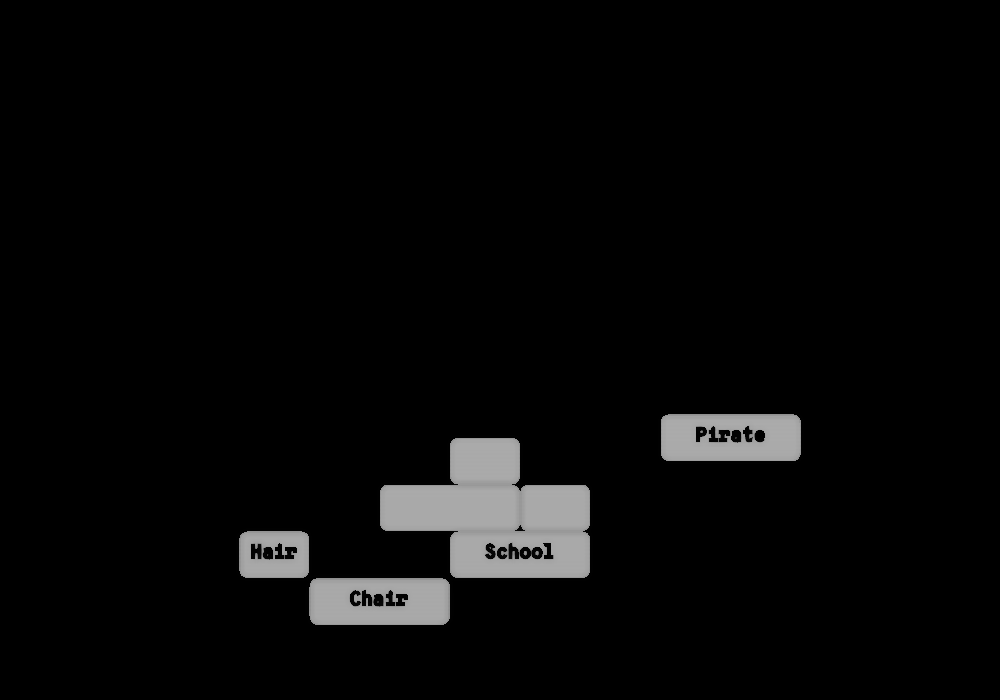

In [17]:
# bilateral filter is effective when you want to
# keep the edges sharp while removing noise
imgray = cv2.bilateralFilter(imgray, 10, 50, 50)
showarray(imgray)

In [18]:
# find contour in gray scale image
_, thresh = cv2.threshold(imgray, 75, 255, 0)
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [19]:
# no of contours found in the image
# word-rectangles attached to each other results in the same contour
len(contours)

4

In [20]:
# finding contour with maximum area
max_area_contour_index = 0
max_area_contour = 0

for i, contour in enumerate(contours):
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    imgray = cv2.drawContours(imgray, [box], 0, (0,255,0), 10)
    
    print('perimeter', cv2.arcLength(contour, True))
    area = cv2.contourArea(contour)
    print('area', area)
    
    if cv2.contourArea(contour) >= max_area_contour:
        max_area_contour = area
        max_area_contour_index = i

perimeter 360.28427052497864
area 6372.0
perimeter 220.04163014888763
area 3117.5
perimeter 732.5096658468246
area 18984.0
perimeter 360.04163002967834
area 6343.5


In [21]:
max_area_contour_index, max_area_contour

(2, 18984.0)

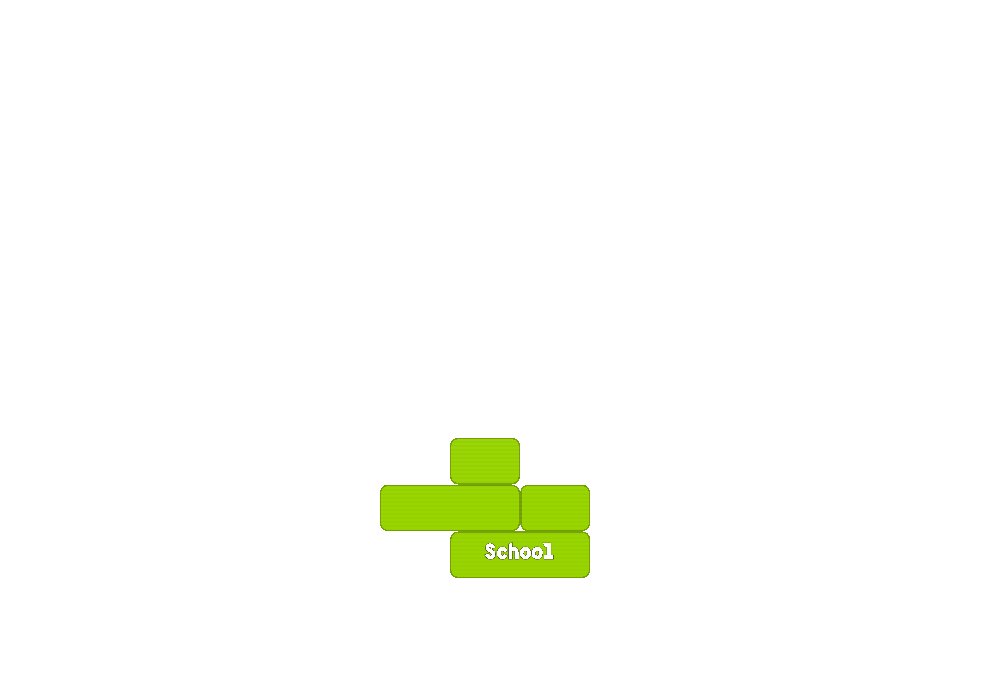

In [22]:
# mask out the image with maximum area contour
mask_contour = np.zeros(imgray.shape[:2], np.uint8)
cv2.drawContours(mask_contour, [contours[max_area_contour_index]],-1, 255, -1)
max_area_contour_image = cv2.bitwise_and(colored_res, colored_res, mask=mask_contour)
showarray(max_area_contour_image)

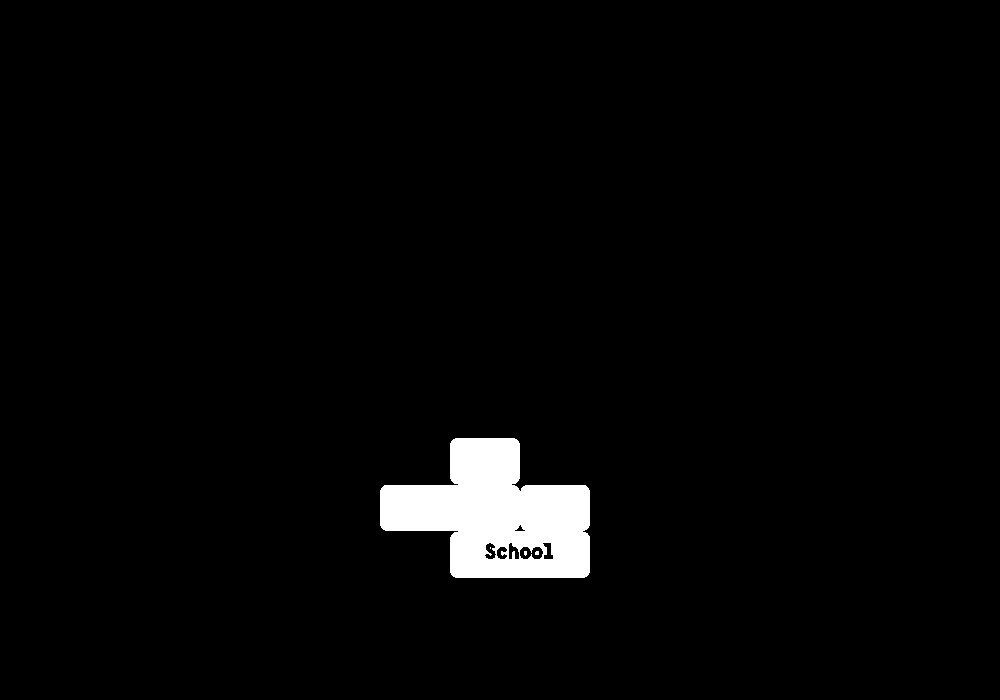

In [23]:
max_area_contour_image_gray = cv2.cvtColor(max_area_contour_image, cv2.COLOR_RGB2GRAY)
(_, max_area_contour_image_bw) = cv2.threshold(
    max_area_contour_image_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU
)
showarray(max_area_contour_image_bw)

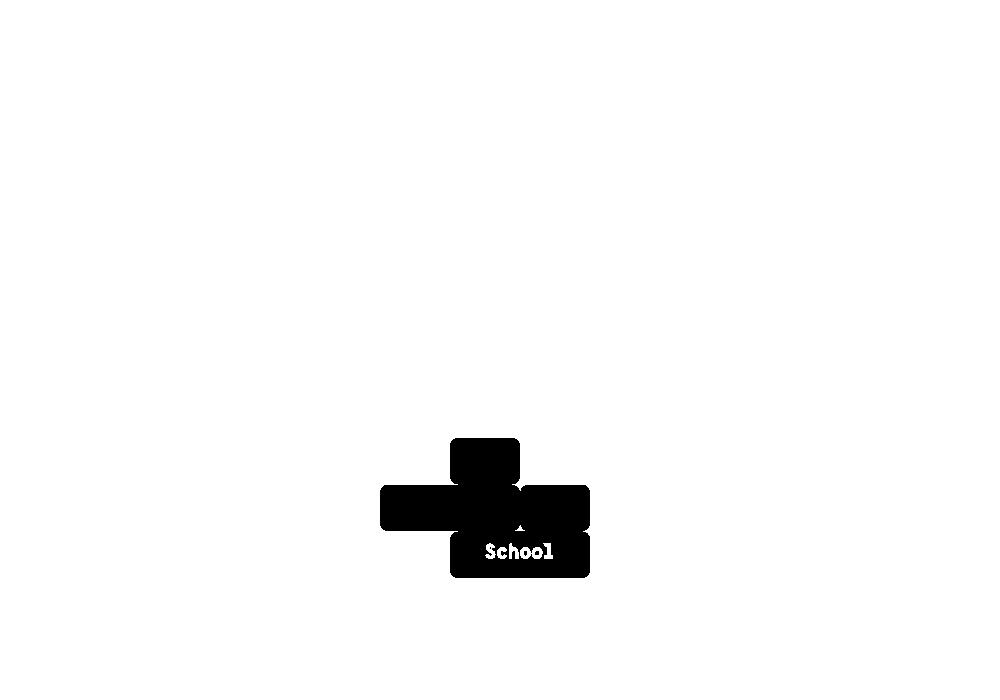

In [24]:
max_area_contour_image_bw_inverted = cv2.bitwise_not(max_area_contour_image_bw)
showarray(max_area_contour_image_bw_inverted)

In [26]:
# Process the contour difference image through OCR/tesseract
pytesseract.image_to_string((max_area_contour_image_bw_inverted - cv2.bitwise_not(mask_contour)))

'School'